## ライブラリのインポート

In [13]:
import math
import os
from collections import Counter

In [14]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sudachipy import dictionary, tokenizer
from tqdm import tqdm

## 読み込み

In [15]:
# Word2Vecモデルの読み込み
print("Word2Vecモデルを読み込んでいます...")
base_dir = os.getcwd()
project_root = os.path.dirname(base_dir)

model_path = os.path.join(project_root, "models", "word2vec_wiki40b_full.wordvectors")
word_vectors = KeyedVectors.load(model_path, mmap="r")
print(f"語彙数: {len(word_vectors):,}語")
print(f"ベクトル次元数: {word_vectors.vector_size}")

# データの読み込み
print("データを読み込んでいます...")
project_df = pd.read_csv(os.path.join(project_root, "data", "raw", "project.csv"))
user_df = pd.read_csv(
    os.path.join(project_root, "data", "raw", "user_work_histories.csv")
)

Word2Vecモデルを読み込んでいます...
語彙数: 393,381語
ベクトル次元数: 300
データを読み込んでいます...


## 前処理関数の定義
テキストから名詞を抽出する関数

In [16]:
# テキスト処理関数
def extract_nouns(text: str) -> list[str]:
    if pd.isna(text):
        return []

    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    mode = tokenizer.Tokenizer.SplitMode.C
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns

## IDF (Inverse Document Frequency) の計算
プロジェクトデータとユーザー職歴データにおける単語の出現頻度を計算し、IDF値（単語のレア度）を算出

In [17]:
# IDFの計算
print("IDFを計算しています...")
all_docs = []
for _, row in project_df.iterrows():
    all_docs.append(f"{row['name']} {row['description']} {row['desired_role']}")

IDFを計算しています...


In [18]:
grouped_user = user_df.groupby("user_id")
for _, group in grouped_user:
    all_texts = []
    for _, row in group.iterrows():
        all_texts.append(f"{row['project_name']} {row['description']} {row['role']}")
    all_docs.append(" ".join(all_texts))

In [19]:
doc_freq = Counter()
total_docs = len(all_docs)

In [20]:
for doc in tqdm(all_docs, desc="文書頻度をカウント中"):
    nouns = set(extract_nouns(doc))  # 文書ごとのユニーク単語数をカウント
    for noun in nouns:
        doc_freq[noun] += 1

文書頻度をカウント中: 100%|██████████| 1300/1300 [00:18<00:00, 70.94it/s]


In [31]:
idf_dict = {}
for word, freq in doc_freq.items():
    idf_dict[word] = math.log(total_docs / (freq + 1)) + 1  # IDFの式

In [22]:
print(f"{len(idf_dict)}語のIDFを計算しました。")

195語のIDFを計算しました。


## ベクトル化関数の定義
Word2Vecの単語ベクトルとIDF重みを用いて、文書ベクトルを作成する関数を定義

In [23]:
# IDF重み付けを用いたcreate_document_vectorの修正版
def create_document_vector(
    text: str, word_vectors: KeyedVectors, idf_dict: dict
) -> np.ndarray:
    nouns = extract_nouns(text)

    vectors = []
    weights = []
    for noun in nouns:
        if noun in word_vectors:
            vectors.append(word_vectors[noun])
            weights.append(
                idf_dict.get(noun, 1.0)
            )  # 見つからない場合はデフォルトの重み1.0

    if len(vectors) == 0:
        return np.zeros(word_vectors.vector_size)

    return np.average(vectors, axis=0, weights=weights)

## プロジェクトのベクトル化

In [24]:
# プロジェクトベクトルの作成
print("プロジェクトベクトルを作成しています...")
project_vectors = []
for idx, row in tqdm(
    project_df.iterrows(), total=len(project_df), desc="プロジェクトベクトル"
):
    combined_text = f"{row['name']} {row['description']} {row['desired_role']}"
    doc_vector = create_document_vector(combined_text, word_vectors, idf_dict)
    project_vectors.append(doc_vector)
project_vectors = np.array(project_vectors)

プロジェクトベクトルを作成しています...


プロジェクトベクトル: 100%|██████████| 1000/1000 [00:14<00:00, 69.93it/s]


## ユーザー職歴のベクトル化

In [25]:
# ユーザープロファイルベクトルの作成
print("ユーザープロファイルベクトルを作成しています...")
grouped = user_df.groupby("user_id")
user_vectors = []
user_ids = []

ユーザープロファイルベクトルを作成しています...


In [26]:
for user_id, group in tqdm(grouped, desc="ユーザープロファイルベクトル"):
    all_texts = []
    for _, row in group.iterrows():
        combined_text = f"{row['project_name']} {row['description']} {row['role']}"
        all_texts.append(combined_text)

    user_text = " ".join(all_texts)
    user_vector = create_document_vector(user_text, word_vectors, idf_dict)

    user_vectors.append(user_vector)
    user_ids.append(user_id)
user_vectors = np.array(user_vectors)

ユーザープロファイルベクトル: 100%|██████████| 300/300 [00:04<00:00, 68.84it/s]


## マッチング処理
プロジェクトとユーザーのベクトルのコサイン類似度を計算

In [27]:
# マッチング関数
def match_candidates_for_project(
    project_idx: int,
    project_vectors: np.ndarray,
    user_vectors: np.ndarray,
    user_ids: list[int],
    top_k: int = 10,
) -> list[tuple[int, float]]:
    project_vector = project_vectors[project_idx].reshape(1, -1)
    similarities = cosine_similarity(project_vector, user_vectors)[0]
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    candidates = [(user_ids[idx], similarities[idx]) for idx in sorted_indices]
    return candidates

In [28]:
# マッチングの実行
print("マッチングを実行しています...")
results = []
for project_idx in tqdm(range(len(project_df)), desc="マッチング"):
    candidates = match_candidates_for_project(
        project_idx, project_vectors, user_vectors, user_ids, top_k=10
    )

    for rank, (user_id, similarity) in enumerate(candidates, 1):
        results.append(
            {
                "project_id": project_df.iloc[project_idx]["id"],
                "project_name": project_df.iloc[project_idx]["name"],
                "desired_role": project_df.iloc[project_idx]["desired_role"],
                "rank": rank,
                "user_id": user_id,
                "similarity_score": similarity,
            }
        )

マッチングを実行しています...


マッチング: 100%|██████████| 1000/1000 [00:00<00:00, 1926.05it/s]


## 結果の出力
マッチング結果をCSVファイルとして保存

In [29]:
matching_results = pd.DataFrame(results)
output_path = os.path.join(project_root, "outputs", "matching_results_idf.csv")
matching_results.to_csv(output_path, index=False)
print(f"マッチング結果を保存しました: {output_path}")

マッチング結果を保存しました: /Users/aokidai/dev/research/outputs/matching_results_idf.csv


## 結果の評価
以前の手法（ベースライン）との比較を行い、結果の変化を確認する

In [30]:
# ベースラインとの比較
baseline_path = os.path.join(project_root, "outputs", "matching_results_wiki.csv")
if os.path.exists(baseline_path):
    print("\nベースラインと比較しています...")
    baseline_df = pd.read_csv(baseline_path)

    # 各プロジェクトのトップ1マッチを比較
    baseline_top1 = baseline_df[baseline_df["rank"] == 1].set_index("project_id")
    new_top1 = matching_results[matching_results["rank"] == 1].set_index("project_id")

    changed_count = 0
    total_projects = len(baseline_top1)

    print(f"{'プロジェクトID':<10} {'ベースライン':<15} {'新規':<15} {'変更あり?'}")
    print("-" * 50)

    for project_id in baseline_top1.index:
        base_user = baseline_top1.loc[project_id, "user_id"]
        new_user = new_top1.loc[project_id, "user_id"]

        changed = base_user != new_user
        if changed:
            changed_count += 1

        if project_id <= 10:  # 簡潔にするため最初の10件を表示
            print(
                f"{project_id:<10} {base_user:<15} {new_user:<15} {'はい' if changed else 'いいえ'}"
            )

    print("-" * 50)
    print(
        f"トップ1ユーザーが変更されたプロジェクト数: {changed_count}/{total_projects} 件 ({changed_count / total_projects:.2%})"
    )
else:
    print("ベースラインファイルが見つかりません。比較をスキップします。")


ベースラインと比較しています...
プロジェクトID   ベースライン          新規              変更あり?
--------------------------------------------------
1          259             259             いいえ
2          259             259             いいえ
3          88              153             はい
4          195             176             はい
5          149             230             はい
6          271             243             はい
7          75              75              いいえ
8          89              89              いいえ
9          4               4               いいえ
10         68              68              いいえ
--------------------------------------------------
トップ1ユーザーが変更されたプロジェクト数: 514/1000 件 (51.40%)


## マッチング結果の詳細表示

In [38]:
# マッチング結果の詳細表示
print("\n=== マッチング結果詳細 (サンプル3件) ===")

# 表示するプロジェクト数
num_samples = 3

for i in range(min(num_samples, len(project_df))):
    project = project_df.iloc[i]
    project_id = project['id']
    print(f"\n{'='*50}")
    print(f"プロジェクトID: {project_id}")
    print(f"プロジェクト名: {project['name']}")
    print(f"募集職種: {project['desired_role']}")
    print(f"詳細: {project['description'][:100]}..." if len(str(project['description'])) > 100 else f"詳細: {project['description']}")
    print(f"{'-'*50}")
    
    # このプロジェクトのマッチング結果を抽出
    project_matches = [r for r in results if r['project_id'] == project_id]
    # 念のためランク順にソート
    project_matches.sort(key=lambda x: x['rank'])
    
    print(f"{'順位':<5} {'ユーザーID':<10} {'スコア':<10} {'ユーザー職種'}")
    print(f"{'-'*50}")
    
    for match in project_matches[:5]: # Top 5を表示
        user_id = match['user_id']
        score = match['similarity_score']
        
        # ユーザー情報の取得（最初のレコードを使用）
        user_rows = user_df[user_df['user_id'] == user_id]
        if not user_rows.empty:
            user_role = user_rows.iloc[0]['role']
        else:
            user_role = "N/A"
            
        print(f"{match['rank']:<5} {user_id:<10} {score:.4f}     {user_role}")


=== マッチング結果詳細 (サンプル3件) ===

プロジェクトID: 1
プロジェクト名: 旅行予約システム設計
募集職種: QAエンジニア
詳細: 当プロジェクトでは運用保守、テスト、デプロイ、ドキュメント作成、自動テスト導入やインフラ構築に取り組んでいる。
--------------------------------------------------
順位    ユーザーID     スコア        ユーザー職種
--------------------------------------------------
1     259        0.8995     エンジニアリングマネージャ
2     258        0.8964     SE
3     197        0.8957     プログラマー
4     66         0.8954     インフラエンジニア
5     283        0.8945     SE

プロジェクトID: 2
プロジェクト名: 予約管理システム設計
募集職種: フルスタックエンジニア
詳細: 現プロジェクトにおいてデータベース設計やデプロイなどに取り組んでいる。
[実施内容]
データベース設計
デプロイ
実装
自動テスト導入
運用保守
パフォーマンス改善
これらの取り組みにより、ユーザー満...
--------------------------------------------------
順位    ユーザーID     スコア        ユーザー職種
--------------------------------------------------
1     259        0.9403     エンジニアリングマネージャ
2     151        0.9358     システムエンジニア
3     66         0.9353     インフラエンジニア
4     73         0.9350     データエンジニア
5     293        0.9339     バックエンドエンジニア

プロジェクトID: 3
プロジェクト名: ブロックチェーン開発実装
募集職種: フルスタックエンジニア
詳細: 要件定

## ユーザー毎のマッチング回数の算出と可視化

マッチング回数の統計 (Rank 1):
  平均: 3.33
  中央値: 1.0
  最大: 41
  最小: 0

マッチングされたユニークユーザー数: 190
全ユーザー数: 300
マッチング回数0のユーザー数: 110
可視化を保存しました: /Users/aokidai/dev/research/outputs/user_match_counts_idf.png


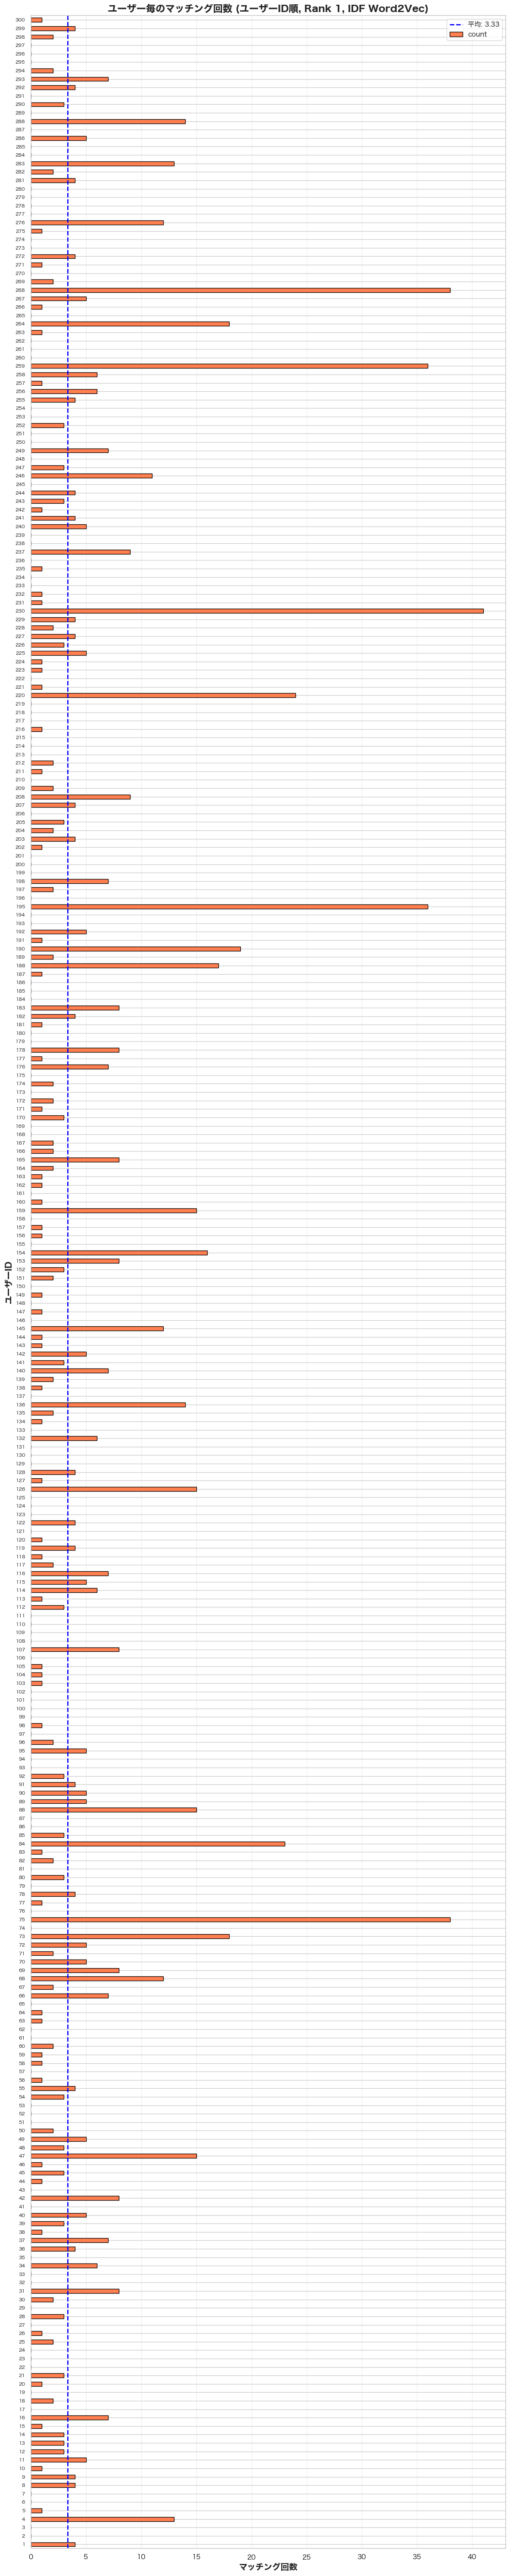

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 日本語フォントの設定 (Mac用)
plt.rcParams['font.family'] = 'Hiragino Sans'

# Rank 1のマッチング結果を抽出
top1_matches = matching_results[matching_results['rank'] == 1]

# 全ユーザーIDのリストを取得
all_user_ids = user_df['user_id'].unique()

# ユーザーごとのマッチング回数を集計（全ユーザーを含む）
user_match_counts = top1_matches['user_id'].value_counts()
user_match_counts = user_match_counts.reindex(all_user_ids, fill_value=0)

# 統計量の計算
count_mean = user_match_counts.mean()
count_median = user_match_counts.median()
count_max = user_match_counts.max()
count_min = user_match_counts.min()

print("マッチング回数の統計 (Rank 1):")
print(f"  平均: {count_mean:.2f}")
print(f"  中央値: {count_median}")
print(f"  最大: {count_max}")
print(f"  最小: {count_min}")

print(f"\nマッチングされたユニークユーザー数: {len(user_match_counts[user_match_counts > 0])}")
print(f"全ユーザー数: {len(all_user_ids)}")
print(f"マッチング回数0のユーザー数: {len(user_match_counts[user_match_counts == 0])}")

# ユーザーIDで昇順にソート
user_match_counts = user_match_counts.sort_index()

# 可視化
fig, ax = plt.subplots(figsize=(12, max(8, len(user_match_counts) * 0.2)))  # 高さを調整
user_match_counts.plot(kind="barh", ax=ax, color="coral", edgecolor="black")

# 平均値のラインを追加
ax.axvline(count_mean, color="blue", linestyle="--", linewidth=2, label=f"平均: {count_mean:.2f}")
ax.legend()

ax.set_xlabel("マッチング回数", fontsize=14, fontweight="bold")
ax.set_ylabel("ユーザーID", fontsize=14, fontweight="bold")
ax.set_title(
    "ユーザー毎のマッチング回数 (ユーザーID順, Rank 1, IDF Word2Vec)", fontsize=16, fontweight="bold"
)
ax.grid(True, alpha=0.3, axis="x")

# y軸のラベル（ユーザーID）が多すぎる場合は間引くか非表示にするなどの調整が必要かもしれないが、
# リファレンス通り全件表示を試みる。ただしフォントサイズを小さくする。
ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
output_path = os.path.join(project_root, "outputs", "user_match_counts_idf.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"可視化を保存しました: {output_path}")
plt.show()